# Heart failure prediction

Kaggle dataset from: https://www.kaggle.com/fedesoriano/heart-failure-prediction

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm

# Selecting color palette
color_palette = 'rocket'

## Info about the data

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

## Loading the data 

In [2]:
df = pd.read_csv('heart.csv')     # Load the dataset
df.info()                         # Checking the info of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [3]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


## Data exploration

### Unique values

In [4]:
# Let's see how many different values we have for each feature
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values.')

Age: 50 unique values.
Sex: 2 unique values.
ChestPainType: 4 unique values.
RestingBP: 67 unique values.
Cholesterol: 222 unique values.
FastingBS: 2 unique values.
RestingECG: 3 unique values.
MaxHR: 119 unique values.
ExerciseAngina: 2 unique values.
Oldpeak: 53 unique values.
ST_Slope: 3 unique values.
HeartDisease: 2 unique values.


### Duplicated rows

In [5]:
# Check for duplicates
df.duplicated().sum()

0

### Categorical and numerical columns

In [6]:
# Check categorical and numerical columns
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [7]:
# Get two lists with categorical and numerical columns (not counting the binary output)
cat_feats = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_feats = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [8]:
# Which are the different categorical values
for col in cat_feats:
    print(f'{col}: {df[col].unique()}')

Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
FastingBS: [0 1]
RestingECG: ['Normal' 'ST' 'LVH']
ExerciseAngina: ['N' 'Y']
ST_Slope: ['Up' 'Flat' 'Down']


### Missing values

In [9]:
# Check for missing values on each column
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Correlation between values

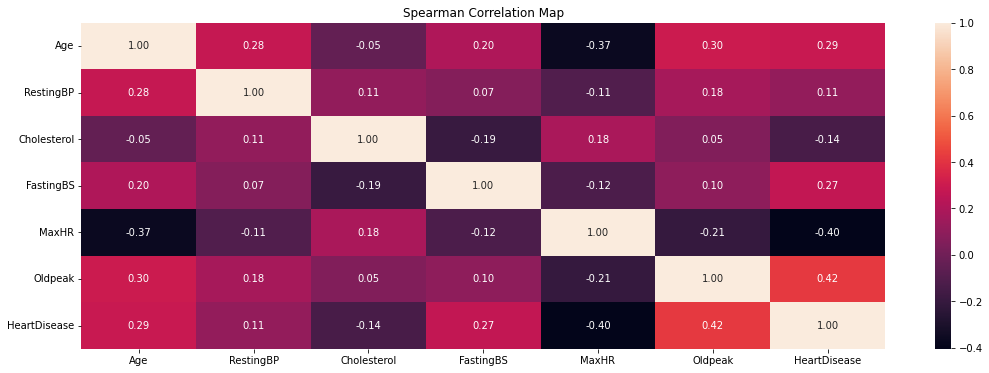

In [10]:
correlation_matrix = df.corr(method = 'spearman')  # get the correlation matrix

# Plot the correlation
plt.figure(figsize = (18, 6))
sns.heatmap(correlation_matrix, annot = True, fmt = '.2f', cmap = color_palette)
plt.title('Spearman Correlation Map')
plt.show()

In [11]:
# Let's get the distribution of the numerical columns w.r.t heart disease
cols_distribution = num_feats
cols_distribution.append('HeartDisease')
cols_distribution

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']

<Figure size 1296x864 with 0 Axes>

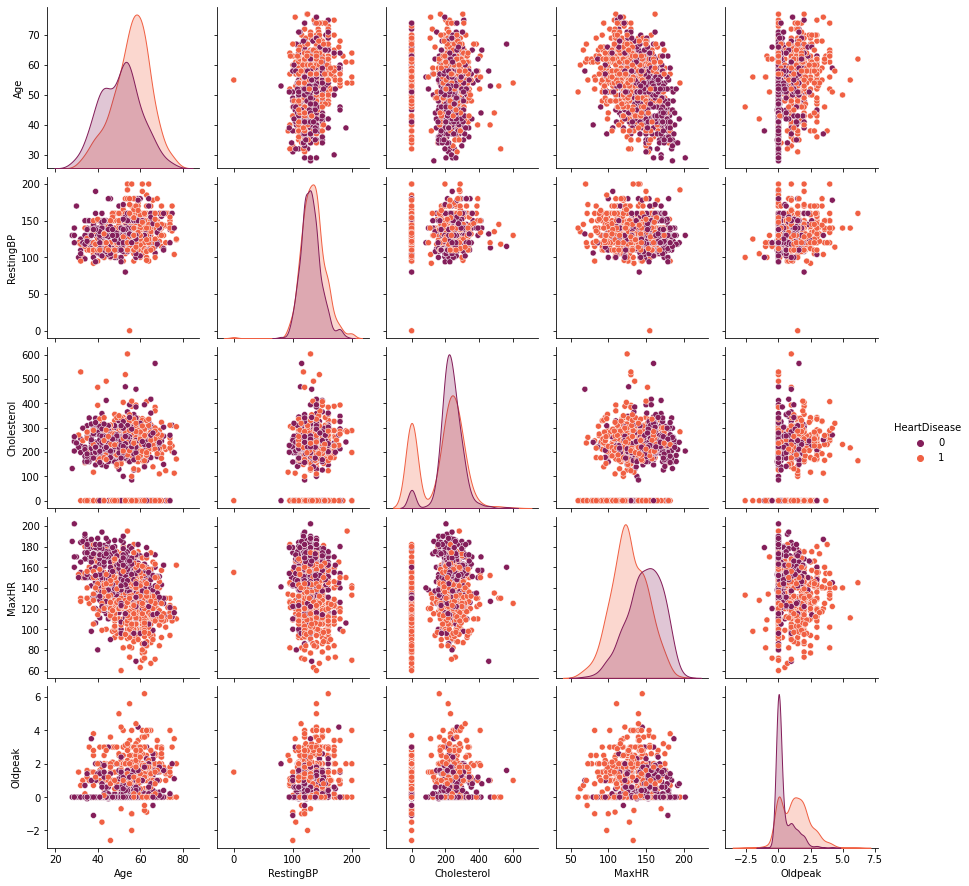

In [12]:
# Plotting
plt.figure(figsize = (18,12))
sns.pairplot(df[cols_distribution], hue = 'HeartDisease', palette = color_palette)
plt.show()

I noticed that for <span style="color:green">'Cholesterol'</span>. and <span style="color:green">'Oldpeak'</span> features, there are quite a few values as 0. 

In [13]:
# Check how many Cholesterol values are equal to 0
count_chol_0 = df.loc[df['Cholesterol'] == 0, 'Cholesterol'].count()
print(f'Cholesterol values == 0: {count_chol_0}')

# Check how many Cholesterol values are equal to 0 and have HeartDisease equal to 1
count_chol_hf_0 = df.loc[(df['Cholesterol'] == 0) & (df['HeartDisease'] == 1), 'Cholesterol'].count()
print(f'Cholesterol values == 0 and HeartDisease == 1: {count_chol_hf_0}')

Cholesterol values == 0: 172
Cholesterol values == 0 and HeartDisease == 1: 152


In [14]:
# Check how many Oldpeak values are equal to 0
count_oldp_0 = df.loc[df['Oldpeak'] == 0, 'Oldpeak'].count()
print(f'Oldpeak values == 0: {count_oldp_0}')

# Check how many Oldpeak values are equal to 0 and have HeartDisease equal to 1
count_oldp_hf_0 = df.loc[(df['Oldpeak'] == 0) & (df['HeartDisease'] == 1), 'Oldpeak'].count()
print(f'Oldpeak values == 0 and HeartDisease == 1: {count_oldp_hf_0}')

Oldpeak values == 0: 368
Oldpeak values == 0 and HeartDisease == 1: 124


Probably, all this 0 values have been created to fill the missing data of the original dataset. 

As we see, for the <span style="color:green">'Cholesterol'</span> features, most of the values equal to 0 have a <span style="color:green">'HeartDisease'</span> value to 1. It does not happend the same on the <span style="color:green">'Oldpeaks'</span>, were this condition is way more balanced. Let's just remove the <span style="color:green">'Cholesterol'</span> column for now.

In [15]:
# Removing the Cholesterol column
df.drop('Cholesterol', axis = 1, inplace = True)
num_feats.remove('Cholesterol')

### Outliers numerical

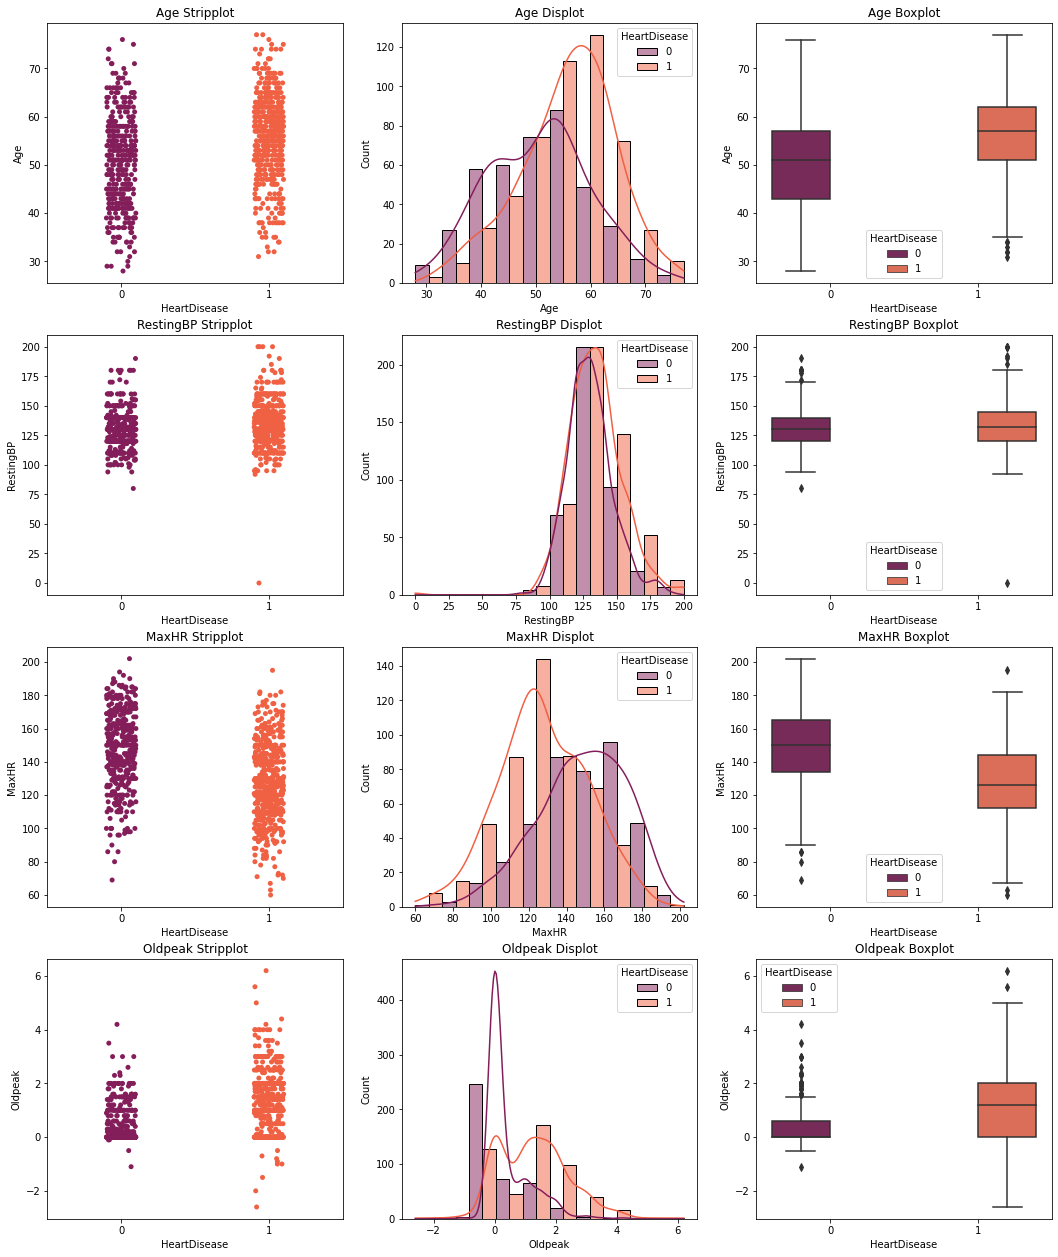

In [16]:
# Plotting numerical values to check if there are outliers
fig, axes = plt.subplots(4, 3, figsize = (18, 22))

for k, col in zip(range(4), num_feats):
    sns.stripplot(ax = axes[k][0], x = 'HeartDisease', y = col, data = df, palette = color_palette, jitter = True)
    axes[k][0].set_title(f'{col} Stripplot')

    sns.histplot(ax = axes[k][1], x = col, data = df, kde = True, bins = 10, palette = color_palette, hue = 'HeartDisease', multiple = 'dodge')
    axes[k][1].set_title(f'{col} Displot')

    sns.boxplot(ax = axes[k][2], x = 'HeartDisease', y = col, data = df, palette = color_palette, hue = 'HeartDisease')
    axes[k][2].set_title(f'{col} Boxplot')

We can see some outliers on the above plot. Let's replace them. For now we will set a threshold with the interquartile range.

In [17]:
# Get the upper and lower limits
def outlier_limits(df, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Replace the values with the limits
def replace_with_limits(df, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_limits(df, variable, q1 = q1, q3 = q3)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit

In [18]:
# Replace outliers
for variable in num_feats:
    replace_with_limits(df, variable)

Let's see if all the outliers are gone.

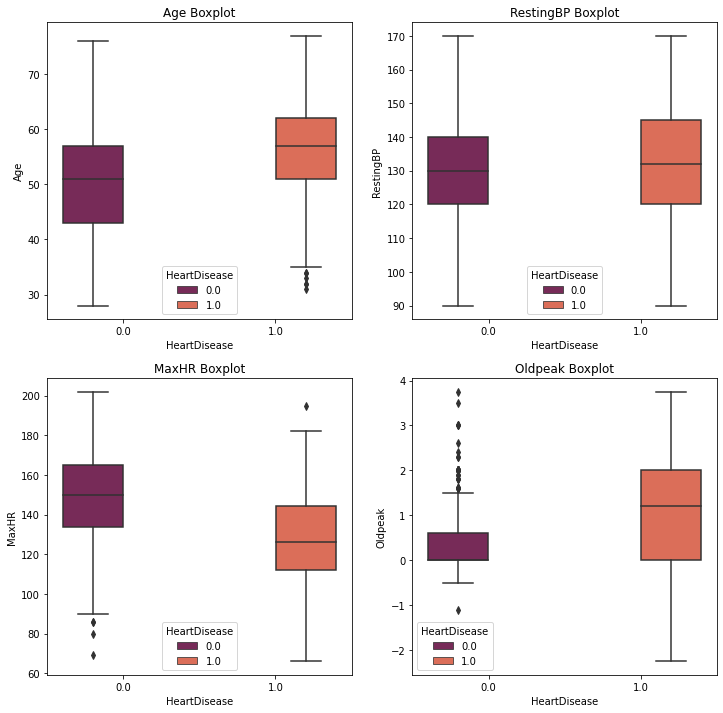

In [19]:
fig, axes = plt.subplots(2, 2, figsize = (12, 12))

for k, col in zip(range(4), num_feats):
    sns.boxplot(ax = axes[k//2][k%2], x = 'HeartDisease', y = col, data = df, palette = color_palette, hue = 'HeartDisease')
    axes[k//2][k%2].set_title(f'{col} Boxplot')

### Categorical Exploration

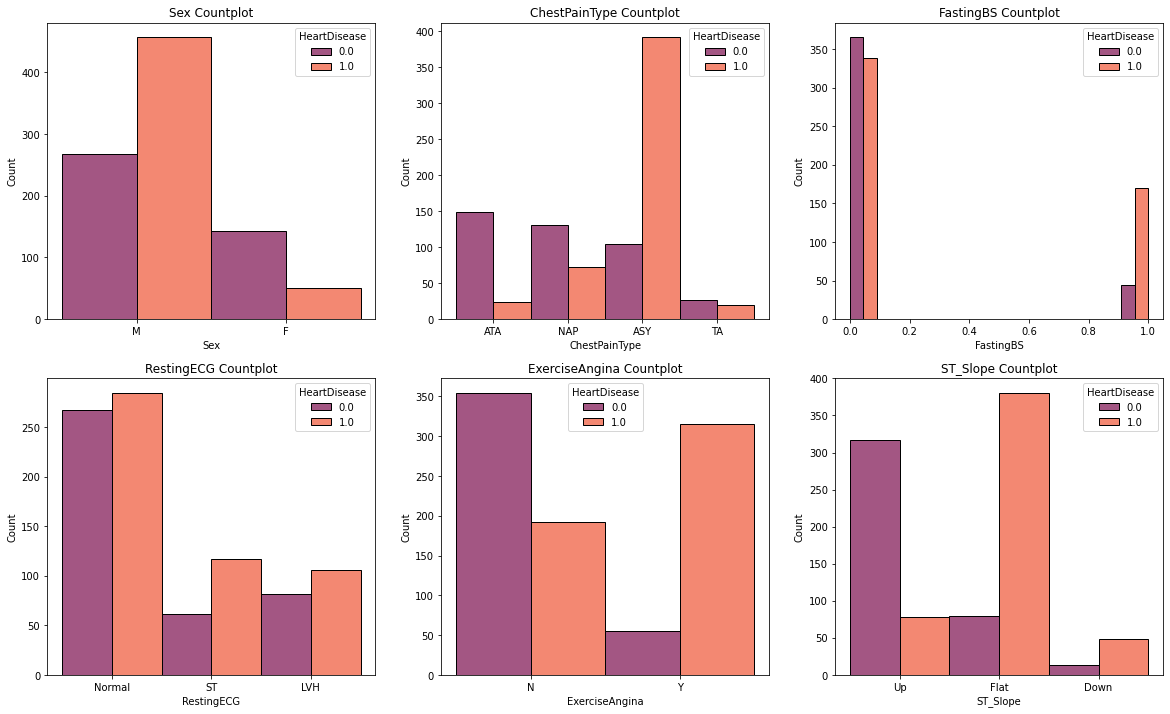

In [20]:
# Let's barplot the counts for each categorical feature
fig, axes = plt.subplots(2, 3, figsize=(20,12))

for i, col in zip(range(6), cat_feats):
    sns.histplot(ax = axes[i//3][i%3], x = col, data = df, palette = color_palette, hue = 'HeartDisease', multiple = 'dodge', bins = 'auto')
    axes[i//3][i%3].set_title(f'{col} Countplot')

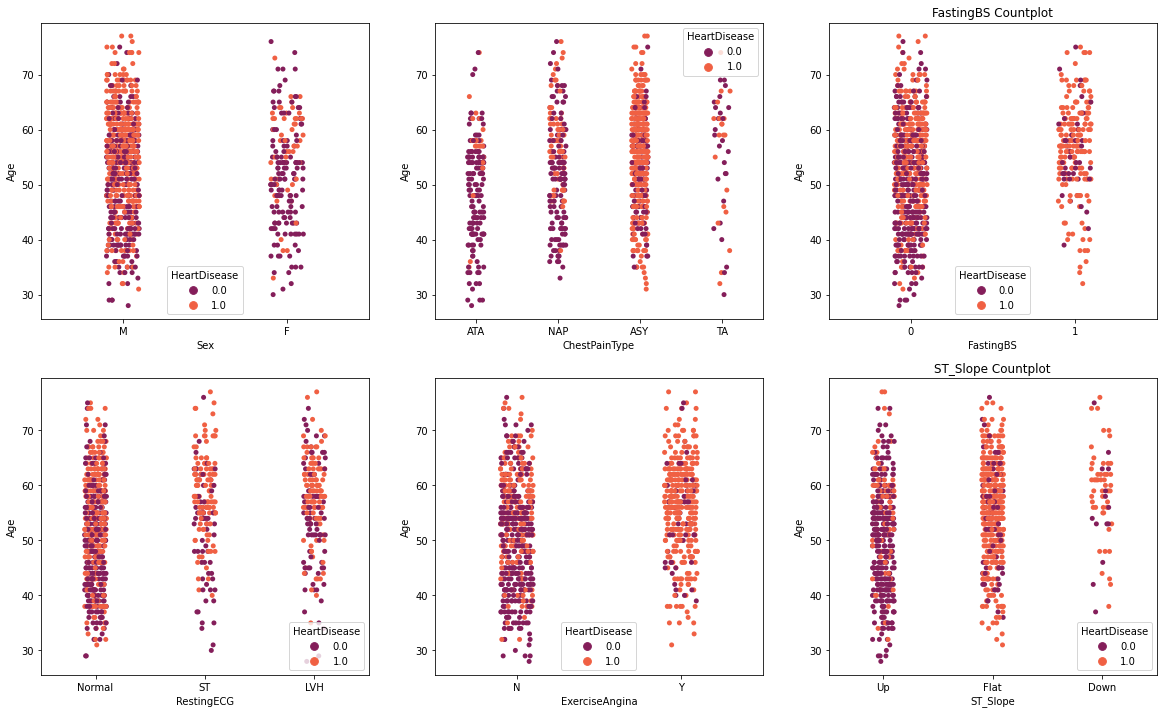

In [21]:
# Let's plot in function of the Age 
fig, axes = plt.subplots(2, 3, figsize=(20,12))

for k, col in zip(range(6), cat_feats):
    sns.stripplot(ax = axes[k//3][k%3], x = col, y = 'Age', data = df, palette = 'rocket', hue = 'HeartDisease', jitter = True)
    axes[k//3][i%3].set_title(f'{col} Countplot')

## Encoding and Dimensionality Reduction

In [22]:
num_feats.remove('HeartDisease')
num_feats, cat_feats

(['Age', 'RestingBP', 'MaxHR', 'Oldpeak'],
 ['Sex',
  'ChestPainType',
  'FastingBS',
  'RestingECG',
  'ExerciseAngina',
  'ST_Slope'])

### Transformers

In [23]:
# We are going to use column transformers to encode certain variables

pca = PCA(n_components = 2)

col_transformer_1 = ColumnTransformer(
    transformers = [
        ('onehotcat', OneHotEncoder(), ['ChestPainType', 'ST_Slope', 'RestingECG', 'Sex', 'ExerciseAngina']),
        ('num', MinMaxScaler(), num_feats)
    ],
    remainder = 'passthrough'
)

col_transformer_2 = ColumnTransformer(
    transformers = [
        ('pca', pca, num_feats)
    ],
    remainder = 'passthrough'
)

col_transformer_1_feats = ['x0_ASY', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Down', 'x1_Flat', 'x1_Up', 
'x2_LVH', 'x2_Normal', 'x2_ST', 'x3_F', 'x3_M', 'x4_N', 'x4_Y', 'Age', 'RestingBP', 'MaxHR', 
'Oldpeak', 'FastingBS']

final_feats = ['PC-1', 'PC-2', 'x0_ATA', 'x0_NAP', 'x0_TA', 'x1_Flat', 'x1_Up', 'x2_Normal', 
'x2_ST', 'x3_M', 'x4_Y', 'FastingBS']

In [24]:
# Get X and y dataframes
X = df.iloc[:,:10]
y = df.iloc[:,10]

X.head(5)

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40.0,M,ATA,140,0,Normal,172,N,0.0,Up
1,49.0,F,NAP,160,0,Normal,156,N,1.0,Flat
2,37.0,M,ATA,130,0,ST,98,N,0.0,Up
3,48.0,F,ASY,138,0,Normal,108,Y,1.5,Flat
4,54.0,M,NAP,150,0,Normal,122,N,0.0,Up


In [25]:
# Apply the first transformation
X = pd.DataFrame(col_transformer_1.fit_transform(X), columns = col_transformer_1_feats)

# we drop 1 feature from each feature that was one hot encoded to avoid multicolinearity
X = X.drop(['x0_ASY', 'x1_Down', 'x2_LVH', 'x3_F', 'x4_N'], axis = 1) 

# Apply the second transformation (pca)
X = pd.DataFrame(col_transformer_2.fit_transform(X), columns = final_feats)
X.head()


,PC-1,PC-2,x0_ATA,x0_NAP,x0_TA,x1_Flat,x1_Up,x2_Normal,x2_ST,x3_M,x4_Y,FastingBS
0,0.268472,0.314646,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,-0.094260,0.372504,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.136854,-0.067667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,-0.105074,-0.037640,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.136472,0.120718,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


### Check for multillinearity 

We are going to use the Variable Inflation Factors (VIF) method. If VIF > 5, it means that the features shows multicollinearity.

In [26]:
# Function to compute the VIF 
def compute_vif(data):

    vif_df = pd.DataFrame(columns = ['Feature', 'VIF'])             # create the dataframe
    x_var_names = data.columns     

    for k in range(0, x_var_names.shape[0]):
        y = data[x_var_names[k]]
        x = data[x_var_names.drop([x_var_names[k]])]

        r_squared = sm.OLS(y,x).fit().rsquared                      # compute VIF
        vif = round(1/(1-r_squared),2)
        
        vif_df.loc[k] = [x_var_names[k], vif]

    return vif_df.sort_values(by = 'VIF', axis = 0, ascending=False, inplace=False)

compute_vif(X)

,Feature,VIF
9,x3_M,4.38
5,x1_Flat,4.10
6,x1_Up,4.06
7,x2_Normal,3.67
10,x4_Y,2.35
8,x2_ST,1.90
2,x0_ATA,1.75
3,x0_NAP,1.51
0,PC-1,1.38
11,FastingBS,1.37


We can see how, having applied PCA, we dont have any features that present multicollinearity.

## Machine Learning algorithms

### Split into train and test

In [27]:
# Let's split tha data into train and test datasets
# For now, we will use 80% of the data for training and 20% for test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

### Useful functions

In [47]:
# Fitting function usgin GridSearchCv
def fit(classifier, params, X, y, k_fold_splits = 10):

    # initialise the GridSearchCV
    grid = GridSearchCV(                             
        classifier, 
        params,
        cv = KFold(n_splits = k_fold_splits),
        n_jobs = 1,
        verbose = 1,
        return_train_score = True,
        scoring = 'accuracy',
        refit = True
        )

    # Fit the model
    grid.fit(X, y)                                   
    
    return grid

# Predictions function
def predict(model, X):
    # Make predictions with the model
    predictions = model.predict(X)
    return predictions

# Plot confusion matrix
def plot_confussion_matrix(y):

    conf_matrix = confusion_matrix(y_true = y_test, y_pred = y)

    fig, ax = plt.subplots(figsize = (6, 6))
    ax.matshow(conf_matrix, cmap = color_palette, alpha = 0.75)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'large') 
    plt.xlabel('Predictions', fontsize = 14)
    plt.ylabel('Actuals', fontsize = 14)
    plt.title('Confusion Matrix', fontsize = 14)
    plt.show()    

# Print the best parameters and best score
def print_bests(model):
    print(f'The best parameters are: {model.best_params_}')          # best parameters
    print(f'The best score that we got is: {model.best_score_}')     # best score

# Print the scores obtained
def print_scores(y_test, y_pred):
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))
    print('ROC-AUC Score: %.3f' % roc_auc_score(y_test, y_pred))

### Logistic Regression

In [29]:
# Dictionnary with the parameters
logistic_regression_parameters = {
    'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
    'penalty': ['l1', 'l2']
}

# Initialise the classifier
logistic_regression_clf = LogisticRegression(
    solver = 'saga', 
    max_iter = 6000
    )

# Fit the model
logistic_regression_model = fit(
    logistic_regression_clf,
    logistic_regression_parameters,
    X_train,
    y_train
)

print_bests(logistic_regression_model)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
The best parameters are: {'C': 0.09, 'penalty': 'l2'}
The best score that we got is: 0.8554609403924471


In [30]:
# Make the predictions on the test
logistic_regression_predictions = predict(
    logistic_regression_model,
    X_test
    )

# Print the scores
print_scores(y_test, logistic_regression_predictions)

Precision: 0.873
Recall: 0.873
Accuracy: 0.859
F1 Score: 0.873
ROC-AUC Score: 0.857


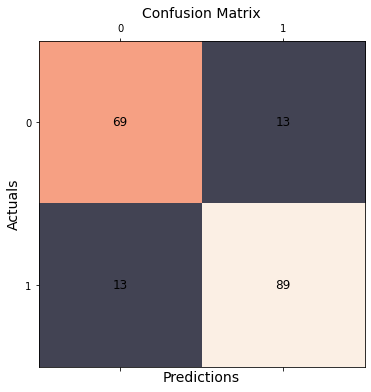

In [48]:
# Get the confussion matrix
plot_confussion_matrix(logistic_regression_predictions)

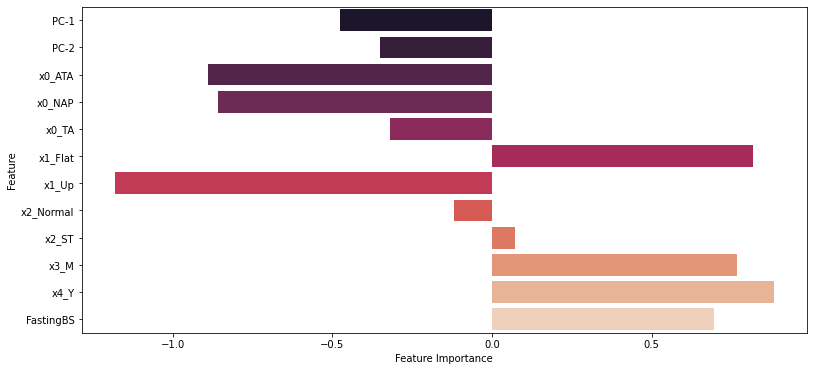

In [38]:
# Get the features importances
logistic_regression_feature_scores = logistic_regression_model.best_estimator_.coef_[0].tolist()

# Create the dataframe
logistic_regression_feature_importance = pd.DataFrame({
    'Feature': final_feats, 
    'Feature Importance': logistic_regression_feature_scores
    })

# PLot the feature importances
plt.figure(figsize = (13, 6))
sns.barplot(
    x = 'Feature Importance', 
    y = 'Feature', 
    data = logistic_regression_feature_importance, 
    palette = color_palette
    )
plt.show()

### Gaussian Naive Bayes

In [44]:
# Dictionnary with the parameters
gnb_parameters = {
    'priors': [None],
    'var_smoothing': np.logspace(0, -9, num = 100)
}

# Initialise the model
gnb_clf = GaussianNB()

# Fit the model
gnb_model = fit(
    gnb_clf,
    gnb_parameters, 
    X_train, 
    y_train
)

print_bests(gnb_model)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
The best parameters are: {'priors': None, 'var_smoothing': 0.08111308307896872}
The best score that we got is: 0.8554794520547946


In [45]:
# Make the predictions on the test
gnb_predictions = predict(
    gnb_model,
    X_test
    )

# Print the scores
print_scores(y_test, gnb_predictions)

Precision: 0.898
Recall: 0.863
Accuracy: 0.870
F1 Score: 0.880
ROC-AUC Score: 0.870


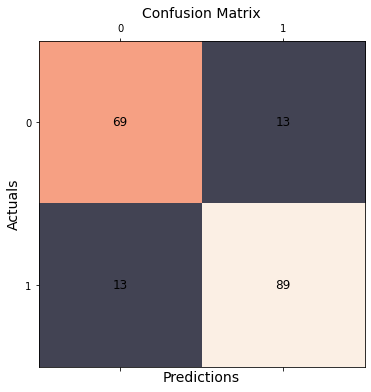

In [49]:
# Get the confussion matrix
plot_confussion_matrix(logistic_regression_predictions)

### K-Nearest Neighbors

In [56]:
# Dictionnary with the parameters
knn_parameters = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']
}

# Initialise the model
knn_clf = KNeighborsClassifier()

# Fit the model
knn_model = fit(
    knn_clf, 
    knn_parameters,
    X_train, 
    y_train
    )

print_bests(knn_model)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
The best parameters are: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
The best score that we got is: 0.8541651240281377
